```
This notebook runs small ensembles in the Oslo fjord where we perturb a
single parameter for each ensemble to look at the resulting variance 
and how it affects a drift trajectory.

Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 9e2194949a236a78754252e0e34f69f9b1e1823f on branch reduced_gravity


In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display
import xarray as xr


#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16
import animation_utils

from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [4]:
%cuda_context_handler gpu_ctx

### Read input file and typical parameters

In [6]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"
source_url = "/lustre/storeB/project/fou/hi/FjordOs/geogrid_tmp/test_polstere_1h_0007.nc"
nc = Dataset(source_url)
ds = xr.open_dataset(source_url)

# Grid and discretization
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [7]:
t_start = 5*24 +20#285
t_stop =  t_start + 6
T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]


### Generating wind

In [10]:
from gpuocean.utils import WindStress

def rotate_wind_field(wind, angle, plot=False):
    radians = (angle/360)*2*np.pi
    wind_u = wind.wind_u.copy()
    wind_v = wind.wind_v.copy()
    t = wind.t.copy()
    #print(t)

    c = np.cos(radians)
    s = np.sin(radians)
    wind_u_new = wind_u * c - wind_v * s
    wind_v_new = wind_u * s + wind_v * c

    if plot:
        x0, x1 = 200, 220
        y0, y1 = 200, 220

        fig = plt.figure()
        plt.quiver(wind_u[3, y0:y1, x0:x1], wind_v[3, y0:y1, x0:x1])

        fig = plt.figure()
        plt.quiver(wind_u_new[3, y0:y1, x0:x1], wind_v_new[3, y0:y1, x0:x1])
    return WindStress.WindStress(t=t, wind_u=wind_u_new, wind_v=wind_v_new)

# Reference values

In [12]:
# Baroclinic initial conditions
ref_barotropic_data_args, ref_baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1024.0, timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)
ref_sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(ref_baroclinic_data_args),  dt=0.0)
barotropic_ref_sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(ref_barotropic_data_args), dt=0.0)

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/utils/WindStress.py:105: RuntimeWarning: overflow encountered in power
  wind_speed = np.sqrt(np.power(wind_u[i], 2) + np.power(wind_v[i], 2))
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modu

In [13]:
ref_wind = ref_baroclinic_data_args["wind"]
ref_wind.wind_u[ref_wind.wind_u > 1e3] = 0.0
ref_wind.wind_v[ref_wind.wind_v > 1e3] = 0.0

In [14]:
ref_wind_rotation = 0.0
ref_wind_stress_factor = 0.3
ref_windage = 0.01

# Perturbation values

In [15]:
# Mixed layer depth (MLD) 
# Can be explored coupled or decoupled with the reduced gravity constant
mld_dens_samples = np.arange(1022, 1024.6, 0.5)
mld_samples_data_args = [None]*len(mld_dens_samples)
recompute_mld_data_args = False
if recompute_mld_data_args or mld_samples_data_args[0] is None:
    for i in range(len(mld_dens_samples)):
        _, mld_samples_data_args[i] = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 
                                                                                        mld_dens_samples[i], timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)
        print(mld_samples_data_args[i]["g"])
print(mld_dens_samples)

#barotropic_data_args1, baroclinic_data_args1 = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1024.1, timestep_indices=timestep_indices, norkyst_data=False, land_value=0.0, download_data=False)

0.03111964720088357
0.02896928153312834
0.026623411608614565
0.02399719727002356
0.02102927229131
0.01762563500452182
[1022.  1022.5 1023.  1023.5 1024.  1024.5]


In [17]:
# Gravity
g_samples = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    g_samples[i] = mld_samples_data_args[i]["g"]

g_extra_samples = np.arange(0.01, 0.11, 0.01)
print(ref_baroclinic_data_args["g"])


0.02102927229131


In [18]:
# Wind
wind_rotations = np.arange(-45, 46, 5)
wind_samples = [None]*len(wind_rotations)

for i in range(len(wind_rotations)):
    wind_samples[i] = rotate_wind_field(ref_wind, wind_rotations[i])

wind_stress_samples = np.arange(0.0, 0.91, 0.1)
windage_samples = np.arange(0.0, 0.0525, 0.0025)

print(len(wind_samples), len(wind_stress_samples), len(windage_samples))

19 10 21


In [19]:
# Friction
print("Reference friction coefficients for baroclinic and barotropic:", ref_baroclinic_data_args["r"], ref_barotropic_data_args["r"])
friction_samples = np.arange(0, 0.0055, 0.0005)
len(friction_samples)

Reference friction coefficients for baroclinic and barotropic: 0.003 0.003


11

### Looking at some of the sample distributions

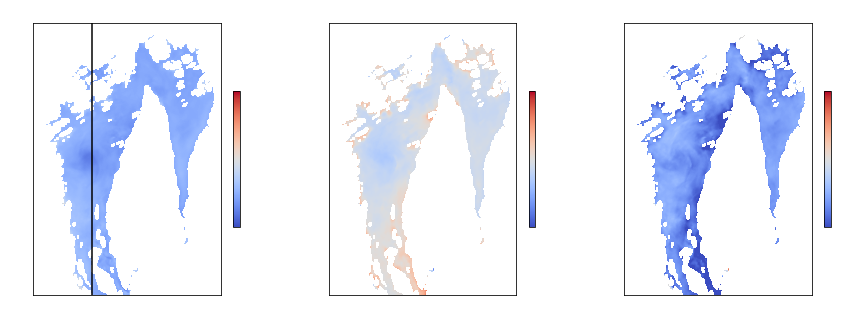

In [20]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

im = axs[0].imshow(mld_samples_data_args[0]["eta0"], vmin=0, vmax=15, cmap="coolwarm")
axs[0].set_title("args1")
plt.colorbar(im, ax=axs[0], shrink=0.5)

axs[0].axvline(x=120, c="black")

num_mld_samples = len(mld_samples_data_args)
im = axs[1].imshow(mld_samples_data_args[num_mld_samples-1]["eta0"], vmin=0, vmax=15, cmap="coolwarm")
axs[1].set_title("args")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(mld_samples_data_args[0]["eta0"]-mld_samples_data_args[num_mld_samples-1]["eta0"], vmin=-5, vmax=5, cmap="coolwarm")
axs[2].set_title("args low - args high")
plt.colorbar(im, ax=axs[2], shrink=0.5)

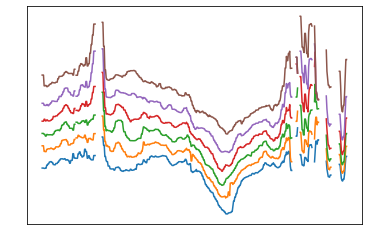

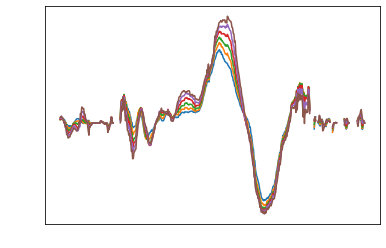

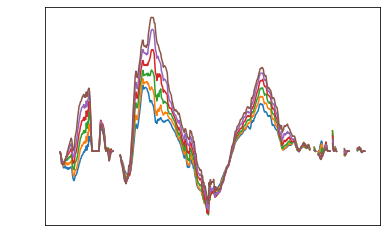

In [21]:
plt.figure()
for i in range(len(mld_samples_data_args)):
    plt.plot(mld_samples_data_args[i]["eta0"][:, 120])

plt.figure()
for i in range(len(mld_samples_data_args)):
    plt.plot(mld_samples_data_args[i]["hu0"][:, 120])

plt.figure()
for i in range(len(mld_samples_data_args)):
    plt.plot(mld_samples_data_args[i]["hv0"][:, 120])



# Utility functions to run ensembles and plot variance and trajectories 

In [22]:
def run_sample(data_args_in, g=None, wind=None, wind_stress_factor=None, windage=0.0, friction=None, end_time=T, pert_init_drifter=False):
    data_args = copy.deepcopy(data_args_in)
    if g is not None:
        data_args["g"] = g
    if wind is not None:
        data_args["wind"] = wind
    if wind_stress_factor is not None:
        data_args["wind_stress_factor"] = wind_stress_factor
    if friction is not None:
        data_args["r"] = friction
    
    # Create sim
    sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(data_args),  dt=0.0)

    # Make observation object to log drift trajectory
    observation_type = dautils.ObservationType.UnderlyingFlow 
    observation_args = {'observation_type': observation_type,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                    }
    trajectories = Observation.Observation(**observation_args)

    # Create and initialize drifter objects
    #initx = [ 6000]
    #inity = [12000]
    initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
    inity = [12000, 3000, 7500, 22000, 16000, 15000]
    num_drifters = len(initx)

    if pert_init_drifter:
        initx += np.random.normal(scale=100, size=num_drifters)
        inity += np.random.normal(scale=100, size=num_drifters)

    drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                        boundaryConditions = sim.boundary_conditions,
                                                        domain_size_x = trajectories.domain_size_x,
                                                        domain_size_y = trajectories.domain_size_y,
                                                        gpu_stream = sim.gpu_stream,
                                                        wind=data_args["wind"],
                                                        wind_drift_factor = windage
                                                        )

    drifter_pos_init = np.array([initx, inity]).T
    drifters.setDrifterPositions(drifter_pos_init)

    # Attach drifters and log init position
    sim.attachDrifters(drifters)
    trajectories.add_observation_from_sim(sim)

    # Simulation loop, logging drifter positions every 2 min
    drifter_log_dt = 2*60
    t = 0
    while t < end_time:
        dt = min(drifter_log_dt, end_time - t)
        sim.step(dt)
        t = t + dt
        trajectories.add_observation_from_sim(sim)

    # return final ocean state and trajectory
    eta, hu, hv = sim.download()
    return {"eta": eta, "hu": hu, "hv": hv, "trajectories": trajectories}


In [23]:

def _get_statistics(results, ref_sim):
    N = len(results)
    etas = np.zeros((N, results[0]["eta"].shape[0], results[0]["eta"].shape[1]))
    hus  = np.zeros((N, results[0]["hu"].shape[0],  results[0]["hu"].shape[1]))
    hvs  = np.zeros((N, results[0]["hv"].shape[0],  results[0]["hv"].shape[1]))
    for i in range(N):
        etas[i,:,:] = results[i]["eta"]
        hus[i,:,:] = results[i]["hu"]
        hvs[i,:,:] = results[i]["hv"]

    _, Hm = ref_sim.downloadBathymetry()


    v = np.sqrt((hus/(etas + Hm))**2 + (hvs/(etas + Hm))**2)

    mean_eta = np.ma.MaskedArray(np.mean(etas, axis=0), mask=results[0]["eta"].mask)
    mean_v   = np.ma.MaskedArray(np.mean(v,    axis=0), mask=results[0]["eta"].mask)
    var_eta  = np.ma.MaskedArray(np.var(etas,  axis=0), mask=results[0]["eta"].mask)
    var_v    = np.ma.MaskedArray(np.var(v,     axis=0), mask=results[0]["eta"].mask)


    return mean_eta, mean_v, var_eta, var_v

zoom0 = [100, 150, 200, 275]
zoom1 = [125, 175,  25, 100]
zoom2 = [ 75, 125, 125, 200]
zoom3 = [ 50, 100, 275, 350]

def _plot_field(results, field, ref_sim, T, title=None, plot_trajectories=True, 
                cmap=plt.cm.Reds, vmin=0.0, vmax=0.5, filename=None, cbar=True, cbar_label=None, zoom=[0,None,0,None],
                quiver=None):
    
    with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(10,10))

        zoom_x0, zoom_x1, zoom_y0, zoom_y1 = zoom

        if zoom_x1 is None:
            dom_x1 = ref_sim.nx
        else:
            dom_x1 = zoom_x1
        if zoom_y1 is None:
            dom_y1 = ref_sim.ny
        else:
            dom_y1 = zoom_y1
        domain_extent = [zoom_x0*ref_sim.dx/1000, dom_x1*ref_sim.dx/1000, zoom_y0*ref_sim.dy/1000, dom_y1*ref_sim.dy/1000]

        cmap_cp = copy.copy(cmap)
        cmap_cp.set_bad("grey", alpha = 1.0)

        im = ax.imshow(field[zoom_y0:zoom_y1, zoom_x0:zoom_x1], interpolation="none", origin='lower', 
                       cmap=cmap_cp, 
                       vmin=vmin, vmax=vmax, 
                       extent=domain_extent)

        ax.tick_params(axis='both', which='major', labelsize=28)

        try:
            lat = np.array(nc.variables["lat_rho"])
            lon = np.array(nc.variables["lon_rho"])

            spec_lat = lat[y0:y1, x0:x1]
            spec_lon = lon[y0:y1, x0:x1]

            cont_lon_case = ax.contour(spec_lon, levels = np.arange( 0, 30, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
            cont_lat_case = ax.contour(spec_lat, levels = np.arange(30, 80, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

        except Exception as e:
            raise e


        if plot_trajectories:
            num_drifters = results[0]["trajectories"].get_num_drifters()
            for d in range(num_drifters):
                for i in range(len(results)):
                    drifter_path = results[i]["trajectories"].get_drifter_path(d, 0, T, in_km = True)[0]
                    start_pos = drifter_path[0,:]

                    if (domain_extent[0] < start_pos[0] < domain_extent[1]) and (domain_extent[2] < start_pos[1] < domain_extent[3]):
                        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                                        0.01, color = 'black',
                                                                        fill=True, zorder=10)
                        ax.add_patch(circ_start)

                        ax.plot(drifter_path[:,0], drifter_path[:,1], color="C0", ls="-", zorder=5)
                        end_pos = drifter_path[-1,:]
                        ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=100, linewidths=2)

        if quiver is not None:
            ax.quiver(quiver[0], quiver[1], quiver[2], quiver[3], scale=5)

        if cbar:
            cb = plt.colorbar(im, ax=ax, shrink=0.9, pad=0.1) #, shrink=0.8)
            cb.ax.tick_params(labelsize=28)
            cb.formatter.set_powerlimits((-2, 2))
            cb.formatter.set_useMathText(True)
            cb.ax.yaxis.offsetText.set_fontsize(24)

        if cbar and cbar_label is not None:
            cb.set_label(label=cbar_label, size=36, labelpad=25)

        if title is not None:
            plt.title(title+"\n", fontsize=16)
        
        plt.tight_layout()

        if filename is not None:
            folder = "sensitivity_figs"
            os.makedirs(folder, exist_ok=True)
            plt.savefig(os.path.join(folder, filename+".pdf"), bbox_inches="tight")


def plot_drifters_and_variance(results, ref_sim, T, suptitle=None, filename=None, vmax=None, cbar=True, cbar_label=None, zoom=[0, None, 0, None]):
    # results are list with dicts [{eta, hu, hv, trajectories}]

    mean_eta, mean_vel, var_eta, var_vel = _get_statistics(results, ref_sim)

    if vmax is None:
        vmax = max(var_vel.max()/4, 1e-6)

    _plot_field(results, var_vel, ref_sim, T, title=suptitle, vmin=0, vmax=vmax, filename=filename, cbar=cbar, cbar_label=cbar_label,  zoom=zoom)
    #_plot_field(results, var_eta, ref_sim, T, "MLD variance", vmin=0, vmax=4)
    
    print("Maximum velocity: ", mean_vel.max(), var_vel.max())

#plot_drifters_and_variance(mld_dens_results, ref_sim, T, "Perturbing MLD init")

# Plot initial positions of the drifters with annotations

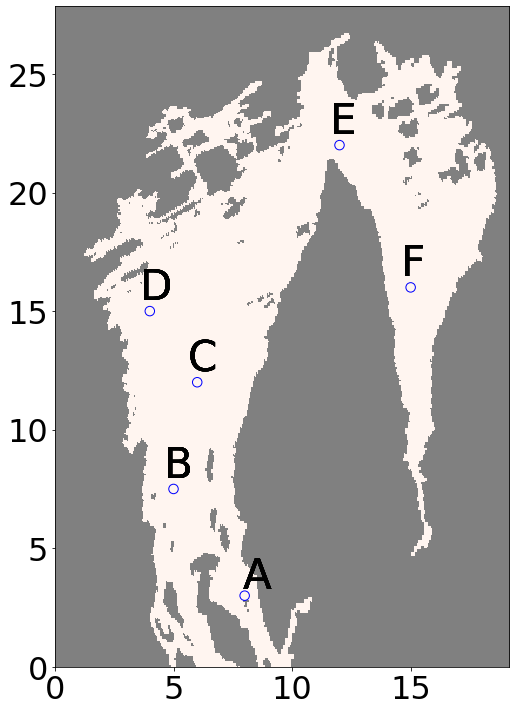

In [24]:
initx = [ 6000, 8000, 5000,  12000, 15000, 4000]
inity = [12000, 3000, 7500, 22000, 16000, 15000]

with plt.rc_context({'lines.color':'black', 
                    'text.color':'black', 
                    'axes.labelcolor':'black', 
                    'xtick.color':'black',
                    'ytick.color':'black'}):
    fig, ax = plt.subplots(1,1, figsize=(10,10))

    domain_extent = [0, ref_sim.nx*ref_sim.dx/1000, 0, ref_sim.ny*ref_sim.dy/1000]

    cmap_cp = copy.copy(plt.cm.Reds)
    cmap_cp.set_bad("grey", alpha = 1.0)
    background_field = np.zeros_like(ref_baroclinic_data_args["eta0"])

    im = ax.imshow(background_field, interpolation="none", origin='lower', 
                cmap=cmap_cp, 
                extent=domain_extent)
    
    ax.tick_params(axis='both', which='major', labelsize=32)

    for d in range(len(initx)):
        circ_start = matplotlib.patches.Circle((initx[d]/1000, inity[d]/1000), 
                                                0.2, color = 'blue',
                                                fill=False, zorder=10)
        ax.add_patch(circ_start)

        # plt.annotate("hei",(initx[0]-1, inity[0]+1))
        annotation_fontsize = 42
        ax.annotate("C",[initx[0]/1000-0.4, inity[0]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("A",[initx[1]/1000-0.1, inity[1]/1000+0.3], fontsize=annotation_fontsize )
        ax.annotate("B",[initx[2]/1000-0.4, inity[2]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("E",[initx[3]/1000-0.4, inity[3]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("F",[initx[4]/1000-0.4, inity[4]/1000+0.5], fontsize=annotation_fontsize )
        ax.annotate("D",[initx[5]/1000-0.4, inity[5]/1000+0.5], fontsize=annotation_fontsize )


    # plt.title("Initial drifter positions\n", fontsize=16)
    plt.tight_layout()

    if True:
        folder = "sensitivity_figs"
        os.makedirs(folder, exist_ok=True)
        plt.savefig(os.path.join(folder, "initial_drifter_positions.pdf"), bbox_inches="tight")

# Run experiments and plot results

Baroclinic reference

In [86]:
ref_baroclinic_data_args["wind"] = WindStress.WindStress(t=[0], wind_u=[np.array([[1]], dtype=np.float32)], wind_v=[np.array([[0]], dtype=np.float32)])

In [96]:
ref_wind.wind_u *= 0.1
ref_wind.wind_v *= 0.1

In [ ]:
ref_baroclinic_data_args 

In [69]:
ref_baroclinic_data_args.pop("wind")

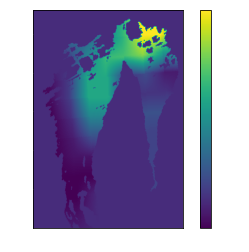

In [93]:
plt.imshow(ref_wind.wind_u[0])
plt.colorbar()

In [88]:
ref_baroclinic_sim = CDKLM16.CDKLM16(gpu_ctx,  **NetCDFInitialization.removeMetadata(ref_baroclinic_data_args),  dt=0.0)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


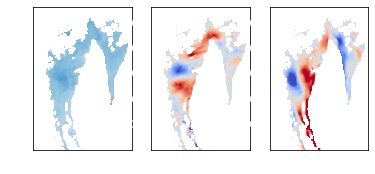

In [89]:
eta, hu, hv = ref_baroclinic_sim.download()

fig, axs = plt.subplots(1,3)
axs[0].imshow(eta, vmin=0, vmax=10, cmap="Blues_r")
axs[1].imshow(hu, vmin=-1, vmax=1, cmap="coolwarm")
axs[2].imshow(hv, vmin=-1, vmax=1, cmap="coolwarm")

In [90]:
ref_baroclinic_sim.step(3600)

3600.0

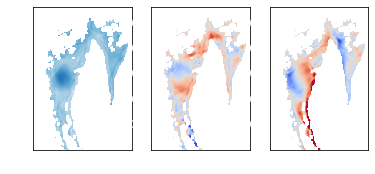

In [91]:
eta, hu, hv = ref_baroclinic_sim.download()

fig, axs = plt.subplots(1,3)
axs[0].imshow(eta, vmin=0, vmax=10, cmap="Blues_r")
axs[1].imshow(hu, vmin=-1, vmax=1, cmap="coolwarm")
axs[2].imshow(hv, vmin=-1, vmax=1, cmap="coolwarm")

In [25]:
ref_baroclinic_result = [run_sample(ref_baroclinic_data_args)]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


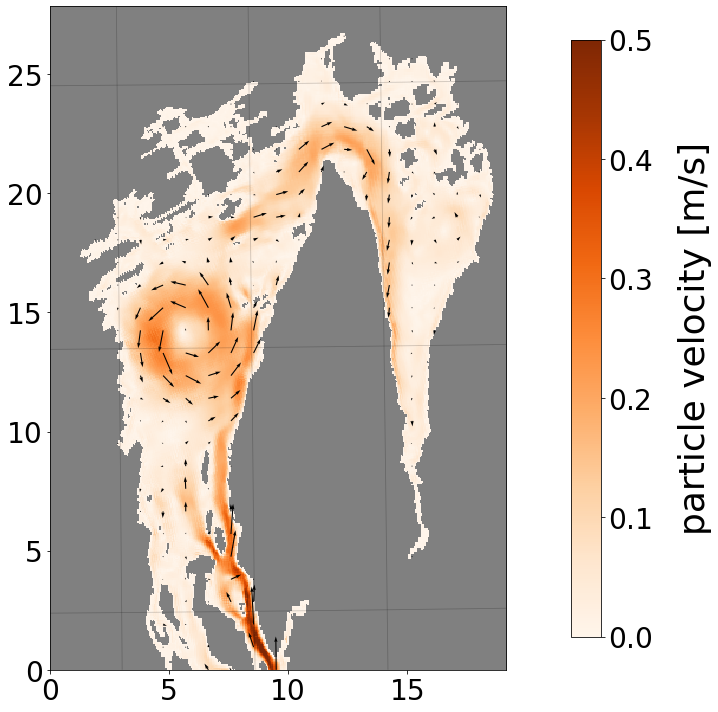

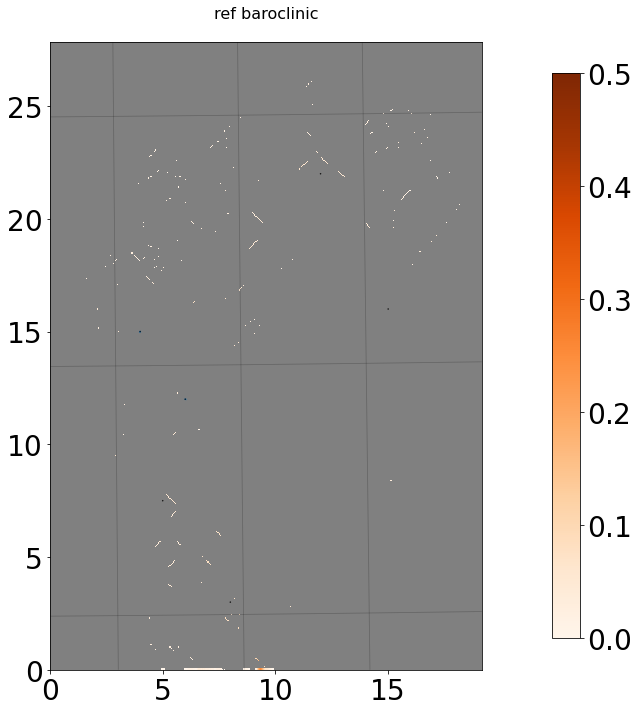

In [26]:
initV = np.ma.sqrt((ref_baroclinic_data_args["hu0"]/ref_baroclinic_data_args["eta0"])**2 + (ref_baroclinic_data_args["hv0"]/ref_baroclinic_data_args["eta0"])**2)

frequency_x = 19
frequency_y = 19
x = np.arange(0, initV.shape[1], frequency_x)*ref_sim.dx/1000
y = np.arange(0, initV.shape[0], frequency_y)*ref_sim.dy/1000
qu = (ref_baroclinic_data_args["hu0"]/ref_baroclinic_data_args["eta0"])[::frequency_y, ::frequency_x]
qv = (ref_baroclinic_data_args["hv0"]/ref_baroclinic_data_args["eta0"])[::frequency_y, ::frequency_x]

_plot_field(ref_baroclinic_result, initV, ref_sim, T, filename="init_baroclinic", plot_trajectories=False, cbar_label="particle velocity [m/s]", cmap=plt.cm.Oranges, quiver=[x,y,qu,qv])


refV = np.ma.sqrt((ref_baroclinic_result[0]["hu"]/ref_baroclinic_data_args["eta0"])**2 + (ref_baroclinic_result[0]["hv"]/ref_baroclinic_data_args["eta0"])**2)
_plot_field(ref_baroclinic_result, refV, ref_sim, T, "ref baroclinic", plot_trajectories=True, cmap=plt.cm.Oranges)

Barotropic reference

In [28]:
ref_barotropic_result = [run_sample(ref_barotropic_data_args)]

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


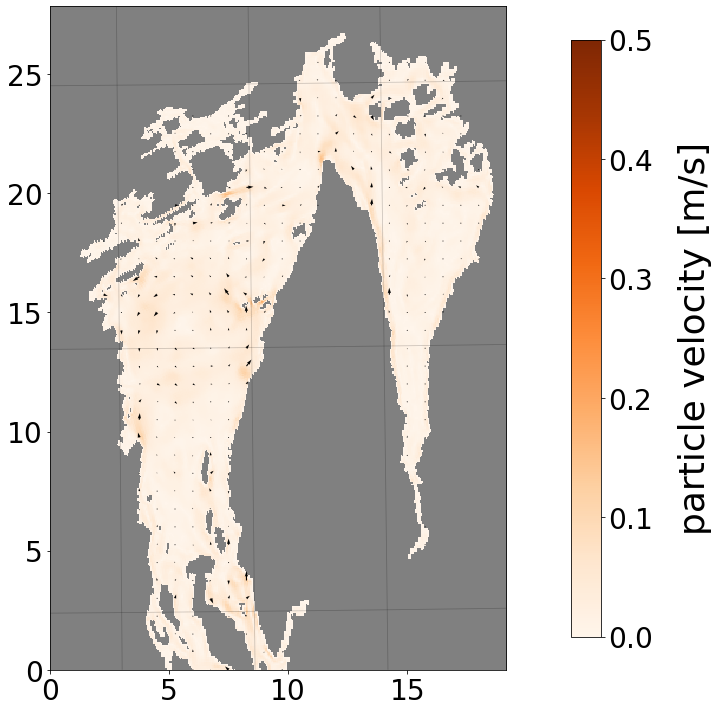

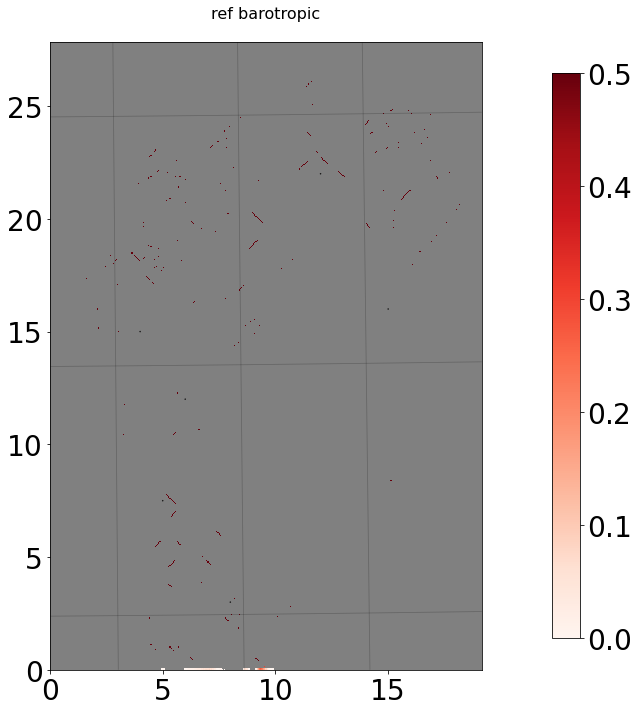

In [29]:
initV = np.ma.sqrt((ref_barotropic_data_args["hu0"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2 + (ref_barotropic_data_args["hv0"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2)

frequency_x = 15
frequency_y = 15
x = np.arange(0, initV.shape[1], frequency_x)*ref_sim.dx/1000
y = np.arange(0, initV.shape[0], frequency_y)*ref_sim.dy/1000
qu = (ref_barotropic_data_args["hu0"]/barotropic_ref_sim.downloadBathymetry()[1])[::frequency_y, ::frequency_x]
qv = (ref_barotropic_data_args["hv0"]/barotropic_ref_sim.downloadBathymetry()[1])[::frequency_y, ::frequency_x]

_plot_field(ref_barotropic_result, initV, ref_sim, T, filename="init_barotropic", plot_trajectories=False, cbar_label="particle velocity [m/s]", cmap=plt.cm.Oranges, quiver=[x,y,qu,qv])


refV = np.ma.sqrt((ref_barotropic_result[0]["hu"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2 + (ref_barotropic_result[0]["hv"]/Dataset(source_url)["h"][y0:y1, x0:x1])**2)
_plot_field(ref_barotropic_result, refV, ref_sim, T, "ref barotropic", plot_trajectories=True)

Barotropic spin-up + wind direction

In [30]:
# barotropic_spinup_wind_results = []
# barotropic_spinup_wind_results_no_windage = []
# for i in range(len(wind_direction_samples[::2])):
#     barotropic_spinup_wind_results.append( run_sample(barotropic_spinup_data_args[i], wind=wind_direction_samples[2*i], windage=ref_windage) )
#     barotropic_spinup_wind_results_no_windage.append( run_sample(barotropic_spinup_data_args[i], wind=wind_direction_samples[2*i], windage=0) )


In [31]:
# plot_drifters_and_variance(barotropic_spinup_wind_results, barotropic_ref_sim, T, filename="barotropic_wind_dir", vmax=2.5e-5, cbar=False)
# plot_drifters_and_variance(barotropic_spinup_wind_results_no_windage, barotropic_ref_sim, T, filename="barotropic_wind_dir_nowindage", vmax=2.5e-5)

In [32]:
# plot_drifters_and_variance(barotropic_spinup_wind_results_no_windage, barotropic_ref_sim, T, filename="barotropic_wind_dir_nowindage_zoom", vmax=2.5e-5, zoom=[50, 100, 250, 325])

### MLD coupled with gravity

In [33]:
# mld_dens_results = [None]*len(mld_dens_samples)
mld_dens_results_no_wind = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    # mld_dens_results[i] = run_sample(mld_samples_data_args[i], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    mld_dens_results_no_wind[i] = run_sample(mld_samples_data_args[i])


/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/utils/WindStress.py:105: RuntimeWarning: overflow encountered in power
  wind_speed = np.sqrt(np.power(wind_u[i], 2) + np.power(wind_v[i], 2))
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was decl

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/utils/WindStress.py:105: RuntimeWarning: overflow encountered in power
  wind_speed = np.sqrt(np.power(wind_u[i], 2) + np.power(wind_v[i], 2))
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/utils/WindStress.py:105: RuntimeWarning: overflow encountered in power
  wind_speed = np.sqrt(np.power(wind_u[i], 2) + np.power(wind_v[i], 2))
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaRead

/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


Maximum velocity:  0.31168714633727473 0.002456733566466099


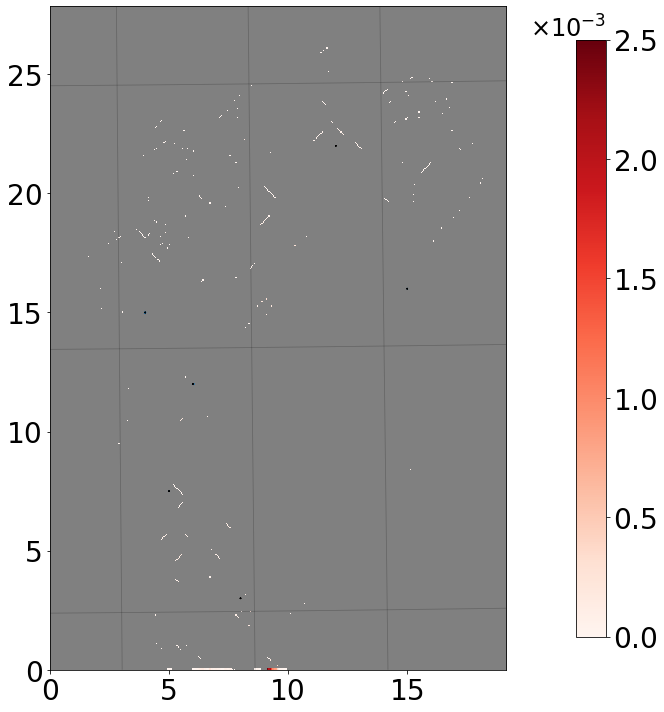

In [34]:
# plot_drifters_and_variance(mld_dens_results, ref_sim, T, filename="mld_coupled_g", vmax=0.0025, cbar=False)
plot_drifters_and_variance(mld_dens_results_no_wind, ref_sim, T, filename="mld_coupled_g_nowind", vmax=0.0025)

### MLD decoupled from gravity

In [35]:
# mld_init_same_g_results = [None]*len(mld_dens_samples)
mld_init_same_g_results_no_wind = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    # mld_init_same_g_results[i] = run_sample(mld_samples_data_args[i], ref_baroclinic_data_args["g"], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    mld_init_same_g_results_no_wind[i] = run_sample(mld_samples_data_args[i], ref_baroclinic_data_args["g"])

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/utils/WindStress.py:105: RuntimeWarning: overflow encountered in power
  wind_speed = np.sqrt(np.power(wind_u[i], 2) + np.power(wind_v[i], 2))
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


Maximum velocity:  0.3116754900456546 0.00245578964119883


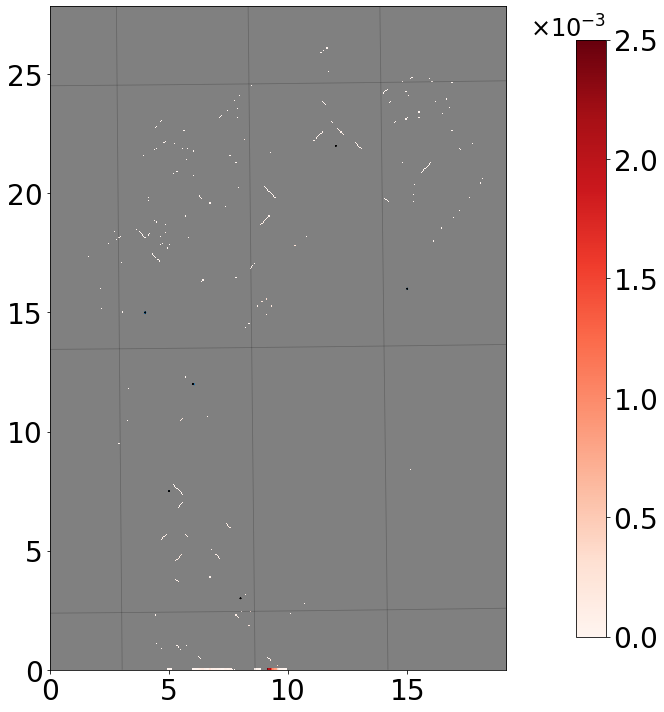

In [36]:
# plot_drifters_and_variance(mld_init_same_g_results, ref_sim, T, filename="mld_decoupled_g", vmax=0.0025, cbar=False)
plot_drifters_and_variance(mld_init_same_g_results_no_wind, ref_sim, T, filename="mld_decoupled_g_nowind", vmax=0.0025)

### Reduced gravity constant, with g computed from different potential densities

In [37]:
# g_results = [None]*len(mld_dens_samples)
g_results_no_wind = [None]*len(mld_dens_samples)
for i in range(len(mld_dens_samples)):
    # g_results[i] = run_sample(ref_baroclinic_data_args, mld_samples_data_args[i]["g"], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    g_results_no_wind[i] = run_sample(ref_baroclinic_data_args, mld_samples_data_args[i]["g"])


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


Maximum velocity:  0.28938490732939565 5.567320857811952e-06


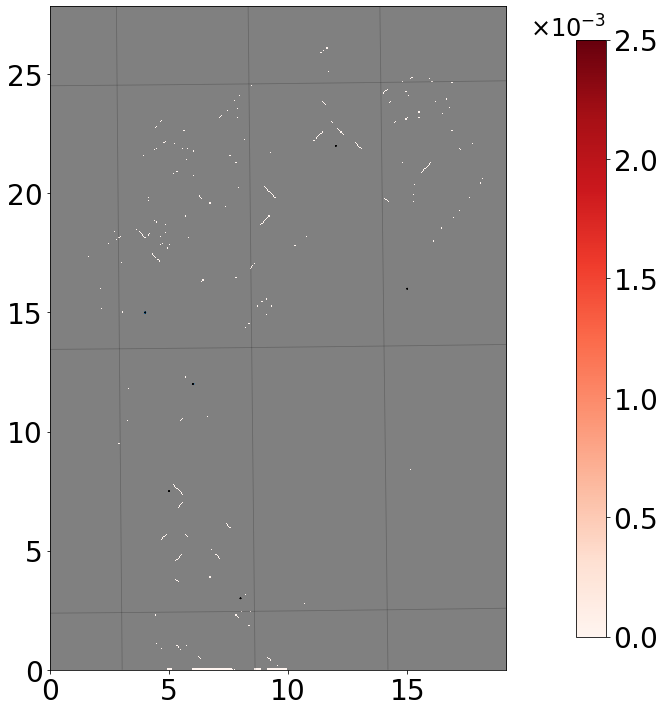

In [38]:
# plot_drifters_and_variance(g_results, ref_sim, T, filename="g_decoupled_mdl", vmax=0.0025, cbar=False)
plot_drifters_and_variance(g_results_no_wind, ref_sim, T, filename="g_decoupled_mdl_nowind", vmax=0.0025)

### Reduced gravities, with g' sampled directly

In [39]:
# g_results2 = [None]*len(g_extra_samples)
g_results2_no_wind = [None]*len(g_extra_samples)
for i in range(len(g_extra_samples)):
    # g_results2[i] = run_sample(ref_baroclinic_data_args, g_extra_samples[i], wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    g_results2_no_wind[i] = run_sample(ref_baroclinic_data_args, g_extra_samples[i])


/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [w

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!


/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


Maximum velocity:  0.2893785455789286 9.265368775164025e-05


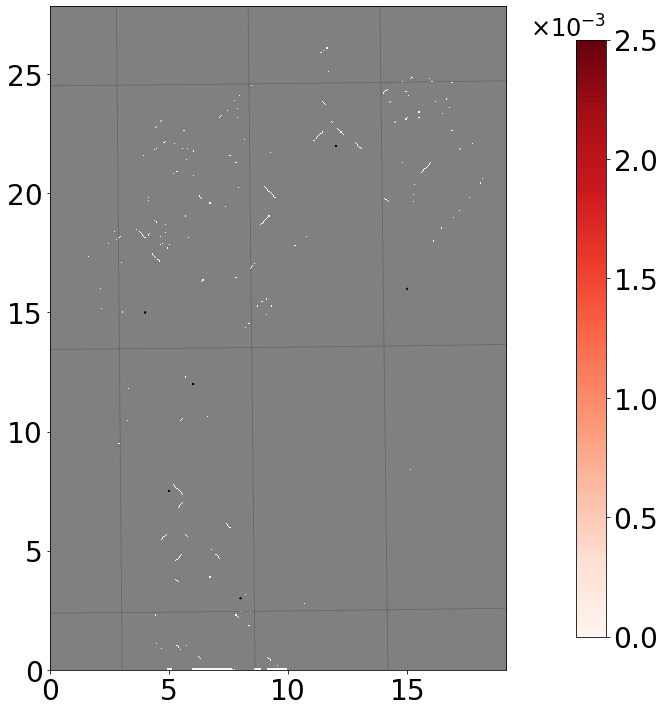

In [40]:
# plot_drifters_and_variance(g_results2, ref_sim, T, filename="g", vmax=0.0025, cbar=False)
plot_drifters_and_variance(g_results2_no_wind, ref_sim, T, filename="g_nowind", vmax=0.0025)

### Wind direction

In [41]:
# wind_direction_results = [None]*len(wind_direction_samples)
wind_direction_results_no_windage = [None]*len(wind_samples)
for i in range(len(wind_samples)):
    # wind_direction_results[i] = run_sample(ref_baroclinic_data_args, wind=wind_direction_samples[i], wind_stress_factor=ref_wind_stress_factor, windage=ref_windage)
    wind_direction_results_no_windage[i] = run_sample(ref_baroclinic_data_args, wind=wind_samples[i], wind_stress_factor=ref_wind_stress_factor, windage=0)


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


Maximum velocity:  0.3058631003212002 0.00011531967385460014


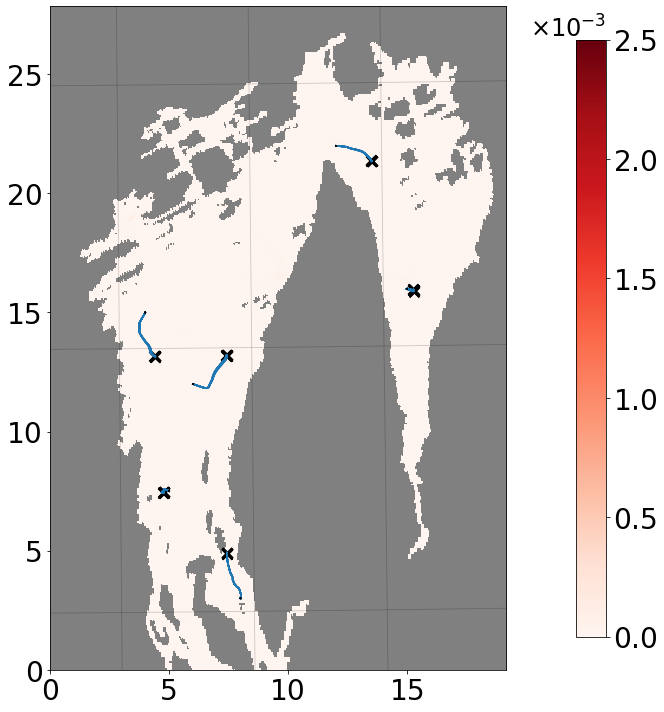

In [42]:
# plot_drifters_and_variance(wind_direction_results, ref_sim, T, filename="wind_direction", vmax=0.0025, cbar=False)
plot_drifters_and_variance(wind_direction_results_no_windage, ref_sim, T, filename="wind_direction_nowindage", vmax=0.0025)


### Wind stress factor

In [43]:
wind_stress_samples = np.arange(0,1.01,0.05)
wind_stress_samples

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [44]:
# wind_stress_results = [None]*len(wind_stress_samples)
wind_stress_results_no_windage = [None]*len(wind_stress_samples)
for i in range(len(wind_stress_samples)):
    # wind_stress_results[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=wind_stress_samples[i], windage=ref_windage)
    wind_stress_results_no_windage[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=wind_stress_samples[i], windage=0)


/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [w

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/ha

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


Maximum velocity:  0.28939638600879936 0.0001851120682453708


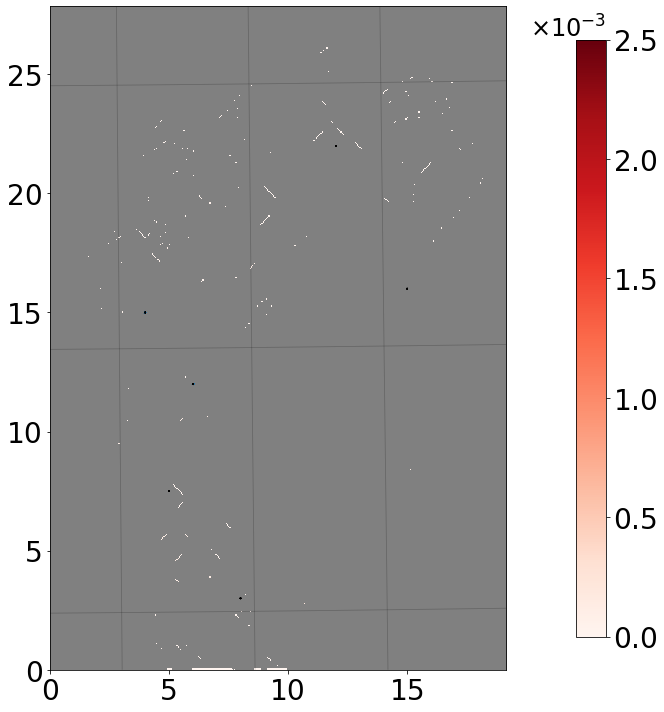

In [45]:
# plot_drifters_and_variance(wind_stress_results, ref_sim, T, filename="wind_stress", vmax=0.0025, cbar=False)
plot_drifters_and_variance(wind_stress_results_no_windage, ref_sim, T, filename="wind_stress_nowindage", vmax=0.0025)

### Interface friction

In [46]:
# friction_results = [None]*len(friction_samples)
friction_results_no_windage = [None]*len(friction_samples)
for i in range(len(friction_samples)):
    # friction_results[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=ref_windage, friction=friction_samples[i])
    friction_results_no_windage[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=0, friction=friction_samples[i])



/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [w

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/ha

This will give inaccurate coriolis along the border!
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(27): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(28): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=float]"
/modules/rhel8/cuda/11.6.0/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

/lustre/storeB/users/florianb/havvarsel/gpuocean/src/gpuocean/gpu_kernels/external_forcing.cu(49): warning #1215-D: function "tex2D(tex

This will give inaccurate coriolis along the border!


/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


Maximum velocity:  0.28939638600879947 0.013044920917787629


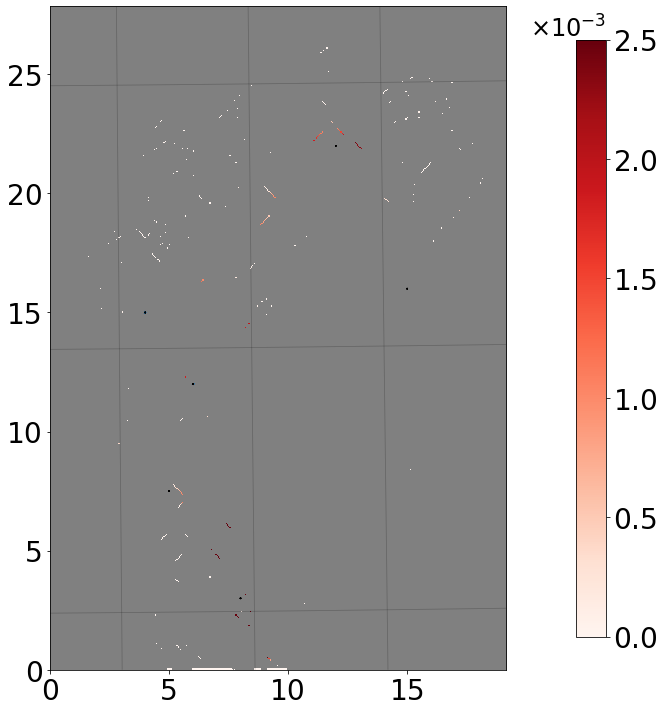

In [47]:
# plot_drifters_and_variance(friction_results, ref_sim, T, filename="interface_friction", vmax=0.0025, cbar=False)
plot_drifters_and_variance(friction_results_no_windage, ref_sim, T, filename="interface_friction_nowindage", vmax=0.0025)

### Windage - wind contribution on advection

In [48]:
windage_results = [None]*len(windage_samples)
for i in range(len(windage_samples)):
    windage_results[i] = run_sample(ref_baroclinic_data_args, wind=ref_wind, wind_stress_factor=ref_wind_stress_factor, windage=windage_samples[i])


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccura

/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


Maximum velocity:  0.28939638600879936 1.9259299443872359e-32


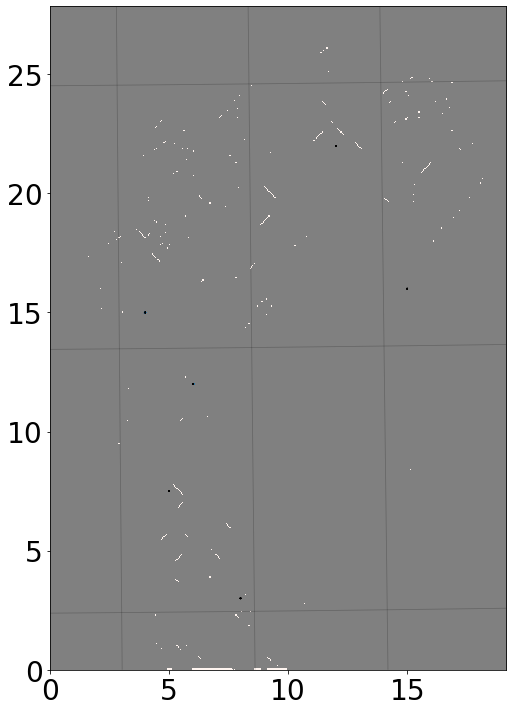

In [49]:
plot_drifters_and_variance(windage_results, ref_sim, T, filename="windage", cbar=False)